In [208]:
from qiskit import *
from math import gcd
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, Aer, execute
from numpy.random import seed, randint

In [209]:
def initialize_qubits(qc, n, m):
    qc.h(range(n))
    qc.x(n+m-1)

In [210]:
def a_x_mod15(a, x):
    U = QuantumCircuit(4)        
    for iteration in range(x):
        U.swap(1,3)
        U.swap(0,2)
        for q in range(4):
            U.x(q)
    U = U.to_gate()
    U.name = f"U({x})"
    c_U = U.control()
    return c_U

In [211]:
def modular_exponentiation(qc, n, m, a):
    for x in range(n):
        exponent = 2**x
        qc.append(a_x_mod15(a, exponent), 
                     [x] + list(range(n, n+m))) 
        
def measure(qc, n):
    qc.measure(n, n)

In [212]:
def apply_iqft(qc, measurement_qubits):
    qc.append(QFT(len(measurement_qubits),do_swaps=False).inverse(),measurement_qubits)

In [213]:
def period_finder(n, m, a):
    qc = QuantumCircuit(n+m, n)
    initialize_qubits(qc, n, m)
    qc.barrier()
    modular_exponentiation(qc, n, m, a)
    qc.barrier()
    apply_iqft(qc, range(n))
    qc.barrier()
    measure(qc, range(n))
    
    return qc

n = 4; m = 4; a = 11
final_circuit = period_finder(n, m, a)

final_circuit.draw(fold=1000)

┌───┐ ░                                      ░ ┌───────┐ ░ ┌─┐         
q_0: ┤ H ├─░─────■────────────────────────────────░─┤0      ├─░─┤M├─────────
     ├───┤ ░     │                                ░ │       │ ░ └╥┘┌─┐      
q_1: ┤ H ├─░─────┼────────■───────────────────────░─┤1      ├─░──╫─┤M├──────
     ├───┤ ░     │        │                       ░ │  IQFT │ ░  ║ └╥┘┌─┐   
q_2: ┤ H ├─░─────┼────────┼────────■──────────────░─┤2      ├─░──╫──╫─┤M├───
     ├───┤ ░     │        │        │              ░ │       │ ░  ║  ║ └╥┘┌─┐
q_3: ┤ H ├─░─────┼────────┼────────┼────────■─────░─┤3      ├─░──╫──╫──╫─┤M├
     └───┘ ░ ┌───┴───┐┌───┴───┐┌───┴───┐┌───┴───┐ ░ └───────┘ ░  ║  ║  ║ └╥┘
q_4: ──────░─┤0      ├┤0      ├┤0      ├┤0      ├─░───────────░──╫──╫──╫──╫─
           ░ │       ││       ││       ││       │ ░           ░  ║  ║  ║  ║ 
q_5: ──────░─┤1      ├┤1      ├┤1      ├┤1      ├─░───────────░──╫──╫──╫──╫─
           ░ │  U(1) ││  U(2) ││  U(4) ││  U(8) │ ░           ░  ║  ║  ║  ║ 
q_6: ──────░─┤2      ├┤2      ├┤2      ├┤2      ├─░───────────░──╫──╫──╫──╫─
     ┌───┐ ░ │       ││       ││       ││       │ ░           ░  ║  ║  ║  ║ 
q_7: ┤ X ├─░─┤3      ├┤3      ├┤3      ├┤3      ├─░───────────░──╫──╫──╫──╫─
     └───┘ ░ └───────┘└───────┘└───────┘└───────┘ ░           ░  ║  ║  ║  ║ 
c: 4/════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                 0  1  2  3

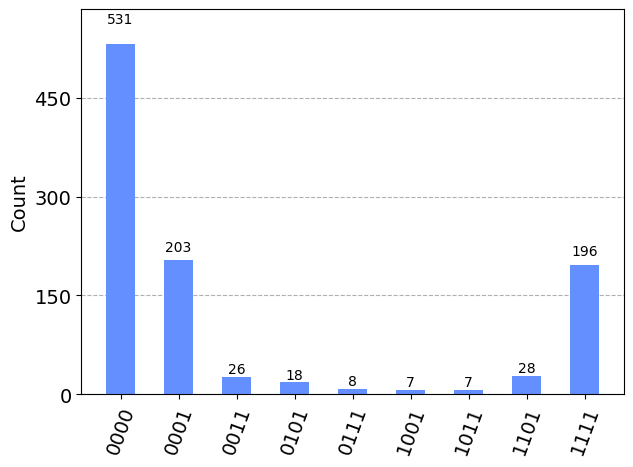

In [214]:
simulator = Aer.get_backend('qasm_simulator')
counts = execute(final_circuit, backend=simulator).result().get_counts(final_circuit)

plot_histogram(counts)

In [215]:
for i in counts:
    measured_value = int(i[::-1], 2)
    if measured_value % 2 != 0:
        continue 
    x = int((a ** (measured_value/2)) % 15)
    if (x + 1) % 15 == 0:
        continue
    factors = gcd(x + 1, 15), gcd(x - 1, 15) 
    print(factors)

(3, 5)
(1, 15)
(1, 15)
(3, 5)
(1, 15)
